In [1]:
import os

data from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=doc

https://crudata.uea.ac.uk/cru/data/hrg/index.htm#current

https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/

https://www.nature.com/articles/s41597-020-0453-3

CRU has a days wet per month variable! that's perfect, even better than precipitation

WET
also has
DTR
which is diurnal temperature range! I need to get that one too

Note 5 in the nature paper confirms it! The min and max temps are means of the daily min max!

In [2]:
from scipy.io import netcdf
import xarray as xr
import pandas as pd
import numpy as np

In [3]:
import geopandas as gpd

In [4]:
import shapely

In [5]:
class TravelMap:

    def __init__(self, data_dir='/home/shrey/Dev/stats_curriculum/geospatial/data/'):

        self.load_data(data_dir)
        self.process_data()
        self.gen_global_grid()
        self.fill_global_grid()
        self.queried_dfs = []

    def load_data(self, data_dir):
        datafiles = os.listdir(data_dir)
        df_list = []
        for file in datafiles:
            ds = xr.open_dataset(data_dir+file)
            df = ds.to_dataframe().reset_index().dropna()
            df_list.append(df)
        df_list = [df.drop(['stn'], axis=1) for df in df_list] # don't need the 'st' column
        self.df_list = df_list

    def process_data(self):
        df_t= self.df_list[0]
        for df in self.df_list[1:]:
            df_t = df_t.merge(df, on=['lon','lat','time'])

        def cels_to_fahr(x):
            """Americuhhh fuck yeahhh"""
            y = 32 + (x*1.8 )
            return y
        
        df_t['tmx_f'] = df_t['tmx'].apply(lambda x: cels_to_fahr(x))
        df_t['tmn_f'] = df_t['tmn'].apply(lambda x: cels_to_fahr(x))
        df_t['tmp_f'] = df_t['tmp'].apply(lambda x: cels_to_fahr(x))

        self.global_df = df_t    
        #self.global_df.reset_index()
        self.global_df['month'] = self.global_df['time'].dt.month
        self.global_df_monthly = self.global_df.drop(['time'],axis=1).groupby(['lat','lon','month']).mean().reset_index()

        self.global_monthly_gdf = gpd.GeoDataFrame(
            self.global_df_monthly, geometry=gpd.points_from_xy(self.global_df_monthly.lon, self.global_df_monthly.lat), crs="EPSG:4326"
        )

    def gen_global_grid(self, N_BOXES = 500):
        #BOXES = 500
        a, b, c, d = (-180.0, -90.0, 180.0, 90.0) # global bounds
        # TODO: it's not number of boxes! actually the num boxes is (N_BOXES-1)**2. instead need to specify coordinate fineness and 
        # write a function that goes from there
        gdf_grid = gpd.GeoDataFrame(
            geometry=[
                shapely.geometry.box(minx, miny, maxx, maxy)
                for minx, maxx in zip(np.linspace(a, c, 361)[:-1], np.linspace(a, c, 361)[1:])
                for miny, maxy in zip(np.linspace(b, d, 181)[:-1], np.linspace(b, d, 181)[1:])
            ],
            crs="epsg:4326",
        )
        self.global_grid_frame = gdf_grid

    def fill_global_grid(self):
        """
        manually verified that on the 1 degree fill this doesn't drop rows in global_monthly_gdf meaning we use all our data when we
        snap it from points to gridded polygons
        """
        self.global_grid_data = gpd.sjoin(self.global_grid_frame, self.global_monthly_gdf, how='left')
    def massage_data(self, data_dir):
        
        datafiles = os.listdir(data_dir)
        df_list = []
        for file in datafiles:
            ds = xr.open_dataset(data_dir+file)
            df = ds.to_dataframe().reset_index().dropna()
            df_list.append(df)
        df_list = [df.drop(['stn'], axis=1) for df in df_list] # don't need the 'st' column
        df_t= df_list[0]
        for df in df_list[1:]:
            df_t = df_t.merge(df, on=['lon','lat','time'])

        def cels_to_fahr(x):
            """Americuhhh fuck yeahhh"""
            y = 32 + (x*1.8 )
            return y
        
        df_t['tmx_f'] = df_t['tmx'].apply(lambda x: cels_to_fahr(x))
        df_t['tmn_f'] = df_t['tmn'].apply(lambda x: cels_to_fahr(x))
        df_t['tmp_f'] = df_t['tmp'].apply(lambda x: cels_to_fahr(x))

        self.global_df = df_t

    def query_by_lat_lon(self, my_lat = 37.77, my_lon = -122.44):
        """
        Queries the global dataframe by lat and lon and then stories the query as well as the results
        """
        #self.queried_df = self.global_df.loc[(np.abs(self.global_df.lon-my_lon)<=0.25) & (np.abs(self.global_df_monthly.lat - my_lat)<=0.25)].groupby('time').agg('mean')

        self.queried_df = self.global_df_monthly.loc[(np.abs(self.global_df_monthly.lon-my_lon)<=0.25) & (np.abs(self.global_df_monthly.lat - my_lat)<=0.25)]
        results_dict = {'lat':my_lat, 'lon':my_lon, 'df':self.queried_df}
        self.queried_dfs.append(results_dict)

In [6]:
my_map = TravelMap()
#my_map.query_by_lat_lon()

In [11]:
str(my_map.global_grid_data.dropna().geometry.iloc[0])


'POLYGON ((-179 -17, -179 -16, -180 -16, -180 -17, -179 -17))'

In [22]:
my_map.global_grid_data.lat==-44.25

0        False
1        False
2        False
3        False
4        False
         ...  
64795    False
64796    False
64797    False
64798    False
64799    False
Name: lat, Length: 855524, dtype: bool

In [36]:
my_map.global_grid_data.loc[(my_map.global_grid_data.lat==-44.25) & (my_map.global_grid_data.lon==-74.25)]

,geometry,index_right,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5284.0,-44.25,-74.25,5.0,163.650009,5.500000,11.300000,5.800000,7 days 17:16:47.961273195,8.400001,52.340000,41.900000,47.120001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5282.0,-44.25,-74.25,3.0,127.950005,9.150001,15.700001,6.550000,3 days 02:38:23.990936281,12.400000,60.260001,48.470001,54.320000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5281.0,-44.25,-74.25,2.0,83.500000,11.850000,16.100000,4.250000,1 days 10:26:24.000205990,13.950001,60.980002,53.330000,57.110001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5285.0,-44.25,-74.25,6.0,169.350006,4.350000,9.350000,5.000000,8 days 00:28:47.998352053,6.850000,48.830001,39.830000,44.330000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5283.0,-44.25,-74.25,4.0,150.250000,8.600000,13.500000,4.900000,5 days 12:21:35.988464355,11.000000,56.300000,47.480000,51.800001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5291.0,-44.25,-74.25,12.0,92.350006,9.600000,17.200001,7.600000,2 days 03:21:35.998764038,13.350000,62.960001,49.280001,56.030000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5290.0,-44.25,-74.25,11.0,91.900002,8.450001,15.350000,6.900000,1 days 23:31:11.991348266,11.850000,59.630000,47.210001,53.330000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5289.0,-44.25,-74.25,10.0,131.750000,6.550000,13.550000,7.000000,5 days 00:21:36.009063718,10.000000,56.390000,43.790000,50.000000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5288.0,-44.25,-74.25,9.0,115.199997,5.500000,11.950001,6.450000,5 days 01:26:23.984756469,8.700001,53.510001,41.900000,47.660001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",5287.0,-44.25,-74.25,8.0,171.300003,4.500000,10.550000,6.050000,7 days 15:07:11.989288330,7.500000,50.990000,40.100000,45.500000


In [38]:
my_map.global_grid_data.loc[(my_map.global_grid_data.lat==-44.75) & (my_map.global_grid_data.lon==-74.75)]

,geometry,index_right,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4933.0,-44.75,-74.75,2.0,81.800003,11.75,15.900000,4.150000,1 days 08:38:23.998661041,13.80,60.620000,53.150001,56.840000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4932.0,-44.75,-74.75,1.0,117.500000,9.50,16.250000,6.750000,1 days 21:43:11.997528078,12.85,61.250000,49.100000,55.130001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4935.0,-44.75,-74.75,4.0,147.400009,8.80,13.400000,4.600000,5 days 12:57:35.996704099,11.05,56.120000,47.840001,51.890000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4936.0,-44.75,-74.75,5.0,155.350006,5.95,11.350000,5.400000,7 days 17:16:47.961273191,8.65,52.430000,42.710000,47.570000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4937.0,-44.75,-74.75,6.0,155.500000,4.95,9.600000,4.650000,7 days 21:14:23.957977294,7.25,49.280001,40.910000,45.050000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4938.0,-44.75,-74.75,7.0,191.800003,4.65,9.750000,5.100000,9 days 07:04:48.006591797,7.20,49.550000,40.370000,44.960000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4939.0,-44.75,-74.75,8.0,160.550003,5.00,10.650000,5.650000,7 days 11:59:59.979400637,7.80,51.170000,41.000000,46.040000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4940.0,-44.75,-74.75,9.0,113.050003,5.95,11.800000,5.850000,4 days 21:35:59.987640380,8.85,53.240000,42.710001,47.930000
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4941.0,-44.75,-74.75,10.0,145.350006,6.60,13.100000,6.500000,4 days 15:43:11.997528074,9.85,55.580001,43.880000,49.730001
18945,"POLYGON ((-74.00000 -45.00000, -74.00000 -44.0...",4942.0,-44.75,-74.75,11.0,82.300003,8.60,14.750000,6.150000,2 days 04:55:11.993408202,11.65,58.550000,47.480000,52.970000


In [30]:
my_map.global_grid_data.loc[(my_map.global_grid_data.lat==-44.75) & (my_map.global_grid_data.lon==-176.75)]

,geometry,index_right,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f


In [31]:
my_map.global_df_monthly.loc[(my_map.global_df_monthly.lat==-44.75) & (my_map.global_df_monthly.lon==-176.75)]

,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f


In [32]:
my_map.global_df_monthly.loc[(my_map.global_df_monthly.lat==-44.75) & (my_map.global_df_monthly.lon==-176.25)]

,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f


In [34]:
my_map.global_df_monthly.loc[(my_map.global_df_monthly.lat==-44.75)].lon.unique()

array([-74.75, -74.25, -73.75, -73.25, -72.75, -72.25, -71.75, -71.25,
       -70.75, -70.25, -69.75, -69.25, -68.75, -68.25, -67.75, -67.25,
       -66.75, -66.25, -65.75, 167.25, 167.75, 168.25, 168.75, 169.25,
       169.75, 170.25, 170.75, 171.25], dtype=float32)

In [35]:
my_map.global_df_monthly.loc[(my_map.global_df_monthly.lat==-44.25)].lon.unique()

array([-176.75,  -74.25,  -73.75,  -73.25,  -72.75,  -72.25,  -71.75,
        -71.25,  -70.75,  -70.25,  -69.75,  -69.25,  -68.75,  -68.25,
        -67.75,  -67.25,  -66.75,  -66.25,  -65.75,  -65.25,  168.25,
        168.75,  169.25,  169.75,  170.25,  170.75,  171.25,  171.75],
      dtype=float32)

In [29]:
my_map.global_df_monthly.lat.unique()

array([-55.75, -55.25, -54.75, -54.25, -53.75, -53.25, -52.75, -52.25,
       -51.75, -51.25, -50.75, -50.25, -49.75, -49.25, -48.75, -48.25,
       -47.75, -47.25, -46.75, -46.25, -45.75, -45.25, -44.75, -44.25,
       -43.75, -43.25, -42.75, -42.25, -41.75, -41.25, -40.75, -40.25,
       -39.75, -39.25, -38.75, -38.25, -37.75, -37.25, -36.75, -36.25,
       -35.75, -35.25, -34.75, -34.25, -33.75, -33.25, -32.75, -32.25,
       -31.75, -31.25, -30.75, -30.25, -29.75, -29.25, -28.75, -28.25,
       -27.75, -27.25, -26.75, -26.25, -25.75, -25.25, -24.75, -24.25,
       -23.75, -23.25, -22.75, -22.25, -21.75, -21.25, -20.75, -20.25,
       -19.75, -19.25, -18.75, -18.25, -17.75, -17.25, -16.75, -16.25,
       -15.75, -15.25, -14.75, -14.25, -13.75, -13.25, -12.75, -12.25,
       -11.75, -11.25, -10.75, -10.25,  -9.75,  -9.25,  -8.75,  -8.25,
        -7.75,  -7.25,  -6.75,  -6.25,  -5.75,  -5.25,  -4.75,  -4.25,
        -3.75,  -3.25,  -2.75,  -2.25,  -1.75,  -1.25,  -0.75,  -0.25,
      

In [16]:
my_map.global_grid_data.dropna().sort_values('geometry').iloc[0:13]

,geometry,index_right,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5277.0,-44.25,-176.75,10.0,56.0,8.900000,13.000000,4.1,3 days 14:23:59.991760256,10.900000,55.400000,48.020000,51.620000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5276.0,-44.25,-176.75,9.0,70.0,6.300000,11.400000,5.1,3 days 07:11:59.995880128,8.800000,52.520000,43.340000,47.840000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5269.0,-44.25,-176.75,2.0,55.0,16.400002,19.900002,3.5,17 days 14:24:00.032958982,18.100000,67.820001,61.520001,64.580001
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5279.0,-44.25,-176.75,12.0,54.0,15.950001,19.150002,3.2,12 days 00:00:00,17.549999,66.470001,60.710001,63.590000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5271.0,-44.25,-176.75,4.0,75.0,11.550000,15.150000,3.6,15 days 12:00:00,13.350000,59.270000,52.790000,56.030001
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5272.0,-44.25,-176.75,5.0,88.0,9.550000,13.350000,3.8,10 days 09:35:59.967041017,11.450001,56.030000,49.190000,52.610001
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5278.0,-44.25,-176.75,11.0,52.0,13.100000,16.500000,3.4,5 days 14:23:59.991760256,14.800000,61.700000,55.580001,58.640000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5273.0,-44.25,-176.75,6.0,93.0,8.450001,12.850000,4.4,5 days 02:23:59.991760256,10.650000,55.130001,47.210001,51.170000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5274.0,-44.25,-176.75,7.0,90.0,6.050000,11.250000,5.2,3 days 09:35:59.987640384,8.650000,52.250000,42.890000,47.570000
585,"POLYGON ((-176.00000 -45.00000, -176.00000 -44...",5275.0,-44.25,-176.75,8.0,79.0,5.950000,10.650000,4.7,1 days 00:00:00,8.250000,51.170000,42.710000,46.850000


In [17]:
str(my_map.global_grid_data.dropna().sort_values('geometry').iloc[0].geometry)

'POLYGON ((-176 -45, -176 -44, -177 -44, -177 -45, -176 -45))'

In [12]:
x= str(my_map.global_grid_data.dropna().geometry.iloc[0])
my_map.global_grid_data.loc[str(my_map.global_grid_data.geometry)==x]

KeyError: 'False: boolean label can not be used without a boolean index'

In [8]:
my_map.global_df_monthly

,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f
0,-55.75,-68.25,1,66.050003,4.750000,12.300000,7.55,12 days 10:11:59.975280760,8.500000,54.140000,40.550000,47.300000
1,-55.75,-68.25,2,53.799999,5.400000,13.150001,7.75,9 days 17:38:23.970336914,9.250000,55.670001,41.720000,48.650000
2,-55.75,-68.25,3,85.850006,4.150000,11.100000,6.95,10 days 00:14:23.978576661,7.600000,51.980000,39.470000,45.680000
3,-55.75,-68.25,4,37.400002,2.800000,9.500000,6.70,8 days 04:11:59.975280760,6.100000,49.100001,37.040000,42.980000
4,-55.75,-68.25,5,40.900002,2.150000,7.400000,5.25,9 days 09:57:35.955505373,4.750000,45.320000,35.870000,40.550000
...,...,...,...,...,...,...,...,...,...,...,...,...
809035,83.75,-28.75,8,5.000000,1.150000,6.600000,5.45,5 days 00:00:00,3.850000,43.880000,34.070000,38.930000
809036,83.75,-28.75,9,7.000000,-9.800000,-5.150000,4.65,7 days 00:00:00,-7.450000,22.730000,14.360000,18.590000
809037,83.75,-28.75,10,0.000000,-23.350000,-17.000000,6.35,0 days 00:00:00,-20.150002,1.399998,-10.030001,-4.270001
809038,83.75,-28.75,11,0.000000,-28.750000,-21.750000,7.00,0 days 00:00:00,-25.250000,-7.150000,-19.750002,-13.450002


In [43]:
my_map.global_grid_gdf

,geometry
0,"POLYGON ((-179.27856 -90.00000, -179.27856 -89..."
1,"POLYGON ((-179.27856 -89.63928, -179.27856 -89..."
2,"POLYGON ((-179.27856 -89.27856, -179.27856 -88..."
3,"POLYGON ((-179.27856 -88.91784, -179.27856 -88..."
4,"POLYGON ((-179.27856 -88.55711, -179.27856 -88..."
...,...
248996,"POLYGON ((180.00000 88.19639, 180.00000 88.557..."
248997,"POLYGON ((180.00000 88.55711, 180.00000 88.917..."
248998,"POLYGON ((180.00000 88.91784, 180.00000 89.278..."
248999,"POLYGON ((180.00000 89.27856, 180.00000 89.639..."


In [44]:
new_gdf = gpd.sjoin(my_map.global_grid_gdf, my_map.global_monthly_gdf, how='left')

In [48]:
new_gdf.dropna().sort_values('geometry').iloc[0:20]

,geometry,index_right,lat,lon,month,pre,tmn,tmx,dtr,wet,tmp,tmx_f,tmn_f,tmp_f
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5277.0,-44.25,-176.75,10.0,56.0,8.900000,13.000000,4.1,3 days 14:23:59.991760256,10.900000,55.400000,48.020000,51.620000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5272.0,-44.25,-176.75,5.0,88.0,9.550000,13.350000,3.8,10 days 09:35:59.967041017,11.450001,56.030000,49.190000,52.610001
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5268.0,-44.25,-176.75,1.0,52.0,16.799999,20.000000,3.2,18 days 14:24:00.032958982,18.400002,68.000000,62.240000,65.120001
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5273.0,-44.25,-176.75,6.0,93.0,8.450001,12.850000,4.4,5 days 02:23:59.991760256,10.650000,55.130001,47.210001,51.170000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5274.0,-44.25,-176.75,7.0,90.0,6.050000,11.250000,5.2,3 days 09:35:59.987640384,8.650000,52.250000,42.890000,47.570000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5275.0,-44.25,-176.75,8.0,79.0,5.950000,10.650000,4.7,1 days 00:00:00,8.250000,51.170000,42.710000,46.850000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5270.0,-44.25,-176.75,3.0,71.0,13.300000,16.900002,3.6,20 days 02:24:00.032958982,15.100000,62.420001,55.940000,59.180000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5278.0,-44.25,-176.75,11.0,52.0,13.100000,16.500000,3.4,5 days 14:23:59.991760256,14.800000,61.700000,55.580001,58.640000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5276.0,-44.25,-176.75,9.0,70.0,6.300000,11.400000,5.1,3 days 07:11:59.995880128,8.800000,52.520000,43.340000,47.840000
2122,"POLYGON ((-176.39279 -44.54910, -176.39279 -44...",5271.0,-44.25,-176.75,4.0,75.0,11.550000,15.150000,3.6,15 days 12:00:00,13.350000,59.270000,52.790000,56.030001


In [ ]:
#my_map.queried_dfs[0]['df']

In [58]:
#my_map.query_by_lat_lon(my_lat = 40.7, my_lon = -73.9)

In [61]:
tdf = my_map.queried_dfs[1]['df']

In [63]:
tdf.loc[tdf.wet<10]

TypeError: Invalid comparison between dtype=timedelta64[ns] and int

# next steps

ok I think I want to incorporate the global_df as a dataframe and then write a function that first displays the info--as a function of month though, so first groupby agg by month (DONE). ok now we want to take it in and display it? or we want an operator that takes in any one of these? because there's going to be subsetting logic too right? so we can subset based on params and then redeploy the map to highlight something.

so easiest way to test this would be to cut the map in half and then test the geodeploy method on it

i think something like this will work:
https://stackoverflow.com/questions/73579250/using-python-to-plot-gridded-map

In [21]:

BOXES = 500
a, b, c, d = (-180.0, -90.0, 180.0, 90.0) # global bounds

# create a grid for Califormia, could be a city
gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.linspace(a, c, BOXES)[:-1], np.linspace(a, c, BOXES)[1:])
        for miny, maxy in zip(np.linspace(b, d, BOXES)[:-1], np.linspace(b, d, BOXES)[1:])
    ],
    crs="epsg:4326",
)

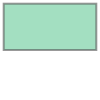

In [24]:
gdf_grid.iloc[0].geometry

In [35]:
len(np.linspace(a, c, BOXES)[:-1])

499

In [28]:
len(np.linspace(a, c, BOXES)[1:])

499

In [53]:
list(zip(np.linspace(a, c, 361), np.linspace(a, c, 361)[1:]))

[(-180.0, -179.0),
 (-179.0, -178.0),
 (-178.0, -177.0),
 (-177.0, -176.0),
 (-176.0, -175.0),
 (-175.0, -174.0),
 (-174.0, -173.0),
 (-173.0, -172.0),
 (-172.0, -171.0),
 (-171.0, -170.0),
 (-170.0, -169.0),
 (-169.0, -168.0),
 (-168.0, -167.0),
 (-167.0, -166.0),
 (-166.0, -165.0),
 (-165.0, -164.0),
 (-164.0, -163.0),
 (-163.0, -162.0),
 (-162.0, -161.0),
 (-161.0, -160.0),
 (-160.0, -159.0),
 (-159.0, -158.0),
 (-158.0, -157.0),
 (-157.0, -156.0),
 (-156.0, -155.0),
 (-155.0, -154.0),
 (-154.0, -153.0),
 (-153.0, -152.0),
 (-152.0, -151.0),
 (-151.0, -150.0),
 (-150.0, -149.0),
 (-149.0, -148.0),
 (-148.0, -147.0),
 (-147.0, -146.0),
 (-146.0, -145.0),
 (-145.0, -144.0),
 (-144.0, -143.0),
 (-143.0, -142.0),
 (-142.0, -141.0),
 (-141.0, -140.0),
 (-140.0, -139.0),
 (-139.0, -138.0),
 (-138.0, -137.0),
 (-137.0, -136.0),
 (-136.0, -135.0),
 (-135.0, -134.0),
 (-134.0, -133.0),
 (-133.0, -132.0),
 (-132.0, -131.0),
 (-131.0, -130.0),
 (-130.0, -129.0),
 (-129.0, -128.0),
 (-128.0, -1

In [37]:
list(zip(np.linspace(a, c, BOXES)[:-1], np.linspace(a, c, BOXES)[1:]))

[(-180.0, -179.27855711422845),
 (-179.27855711422845, -178.55711422845692),
 (-178.55711422845692, -177.83567134268537),
 (-177.83567134268537, -177.11422845691382),
 (-177.11422845691382, -176.3927855711423),
 (-176.3927855711423, -175.67134268537075),
 (-175.67134268537075, -174.9498997995992),
 (-174.9498997995992, -174.22845691382764),
 (-174.22845691382764, -173.50701402805612),
 (-173.50701402805612, -172.78557114228457),
 (-172.78557114228457, -172.06412825651302),
 (-172.06412825651302, -171.3426853707415),
 (-171.3426853707415, -170.62124248496994),
 (-170.62124248496994, -169.8997995991984),
 (-169.8997995991984, -169.17835671342687),
 (-169.17835671342687, -168.4569138276553),
 (-168.4569138276553, -167.73547094188376),
 (-167.73547094188376, -167.01402805611224),
 (-167.01402805611224, -166.2925851703407),
 (-166.2925851703407, -165.57114228456913),
 (-165.57114228456913, -164.84969939879758),
 (-164.84969939879758, -164.12825651302606),
 (-164.12825651302606, -163.4068136

In [70]:
gdf_grid

,geometry
0,"POLYGON ((-179.27856 -90.00000, -179.27856 -89..."
1,"POLYGON ((-179.27856 -89.63928, -179.27856 -89..."
2,"POLYGON ((-179.27856 -89.27856, -179.27856 -88..."
3,"POLYGON ((-179.27856 -88.91784, -179.27856 -88..."
4,"POLYGON ((-179.27856 -88.55711, -179.27856 -88..."
...,...
248996,"POLYGON ((180.00000 88.19639, 180.00000 88.557..."
248997,"POLYGON ((180.00000 88.55711, 180.00000 88.917..."
248998,"POLYGON ((180.00000 88.91784, 180.00000 89.278..."
248999,"POLYGON ((180.00000 89.27856, 180.00000 89.639..."
